In [1]:
import xplot as xplt

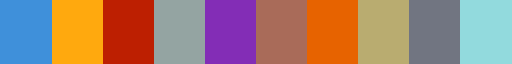

In [2]:
xplt.cmap_petroff

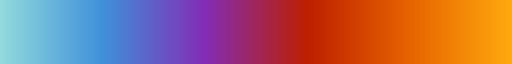

In [3]:
xplt.cmap_petroff_gradient

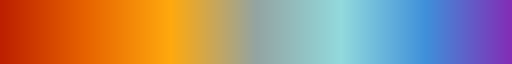

In [4]:
xplt.cmap_petroff_bipolar

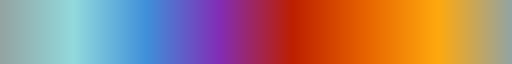

In [5]:
xplt.cmap_petroff_cyclic